In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

iris = load_iris()
X_full, y_full = iris.data, iris.target

# 모델 선정(생성)
# random_state = 42 -> 동일한 결과를 얻기 위해서
clf = DecisionTreeClassifier(random_state=42)
# 모델 학습(fit)
clf.fit(X_full, y_full)

# 예측
y_pred_full = clf.predict(X_full)

# 정확도 평가
print(f"Accuracy: {accuracy_score(y_full, y_pred_full):.3f}")

Accuracy: 1.000


In [ ]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
#데이터를 5개로 쪼개고, 섞음
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_scores = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_full, y_full), 1):
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_full[train_idx], y_full[train_idx])
    score = accuracy_score(y_full[test_idx], model.predict(X_full[test_idx]))
    fold_scores.append((fold, score))

df_scores = pd.DataFrame(fold_scores, columns = ["Fold", "Accuracy"])
display(df_scores)
print("평균=%.3f, 표준편차=%.3f" % (df_scores['Accuracy'].mean(), df_scores['Accuracy'].std()))


,Fold,Accuracy
0,1,1.000000
1,2,0.966667
2,3,0.933333
3,4,0.966667
4,5,0.900000


평균=0.953, 표준편차=0.038


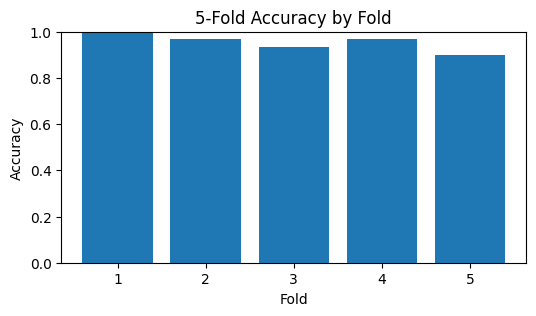

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize = (6,3))
plt.bar(df_scores["Fold"], df_scores["Accuracy"])
plt.ylim(0,1)
plt.title("5-Fold Accuracy by Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()

In [7]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    DecisionTreeClassifier(random_state=42),
    X_full, y_full, cv=5, scoring="accuracy"
)
print(f"[cross_val_score] mean={cv_scores.mean()}")

[cross_val_score] mean=0.9533333333333334


In [9]:
import pandas as pd

depth_candidates = [2,3,4,None]
rows = []

for d in depth_candidates:
    scores = cross_val_score(
        DecisionTreeClassifier(max_depth=d,random_state=42),
        X_full, y_full, cv=5, scoring="accuracy"
    )
    rows.append((d, scores.mean(), scores.std()))


df_depth = pd.DataFrame(rows, columns=["max_depth","cv_mean_acc", "cv_std"]).sort_values("cv_mean_acc", ascending=False).reset_index(drop=True)
display(df_depth)

,max_depth,cv_mean_acc,cv_std
0,3.0,0.973333,0.024944
1,4.0,0.953333,0.033993
2,NaN,0.953333,0.033993
3,2.0,0.933333,0.047140


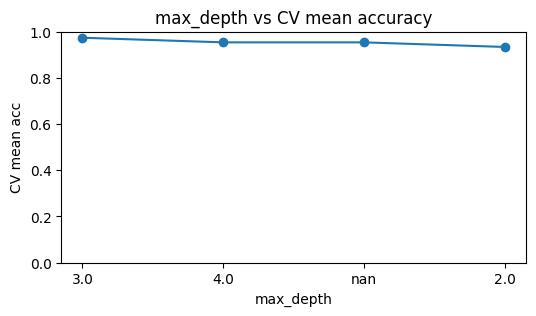

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
x = [str(d) for d in df_depth["max_depth"]]
plt.plot(x, df_depth["cv_mean_acc"], marker="o")
plt.ylim(0, 1)
plt.title("max_depth vs CV mean accuracy")
plt.xlabel("max_depth")
plt.ylabel("CV mean acc")
plt.show()


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [2,3,4, None],
    "min_samples_split": [2,4,8]
}

gs = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5, scoring="accuracy",
    n_jobs=-1,
    refit=True
)
gs.fit(X_full, y_full)
print(f"best_params_: {gs.best_params_}")
print(f"best_score_ : {gs.best_score_:.3f}")


best_params_: {'max_depth': 3, 'min_samples_split': 2}
best_score_ : 0.973


In [13]:
cvres = pd.DataFrame(gs.cv_results_)
cols = ["mean_test_score", "std_test_score", "param_max_depth", "param_min_samples_split"]
cvres[cols].sort_values("mean_test_score", ascending=False).head(10)

,mean_test_score,std_test_score,param_max_depth,param_min_samples_split
3,0.973333,0.024944,3,2
4,0.973333,0.024944,3,4
5,0.973333,0.024944,3,8
11,0.966667,0.021082,None,8
8,0.966667,0.021082,4,8
7,0.953333,0.033993,4,4
9,0.953333,0.033993,None,2
6,0.953333,0.033993,4,2
10,0.953333,0.033993,None,4
2,0.933333,0.047140,2,8


In [14]:
from sklearn.model_selection import train_test_split

best_model = gs.best_estimator_
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size = 0.2, stratify=y_full
)
best_model.fit(X_train, y_train)
final_acc = accuracy_score(y_test, best_model.predict(X_test))
print(f"[최종 홀드아웃] Accuracy: {final_acc:.3f}")

[최종 홀드아웃] Accuracy: 0.867
